 #### Coded by: Vikranth

In [14]:
import pandas as pd
from sklearn import ensemble
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.io
%matplotlib notebook

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.models import load_model

(179962, 15)
(69818, 3)
(69818, 15)


<IPython.core.display.Javascript object>


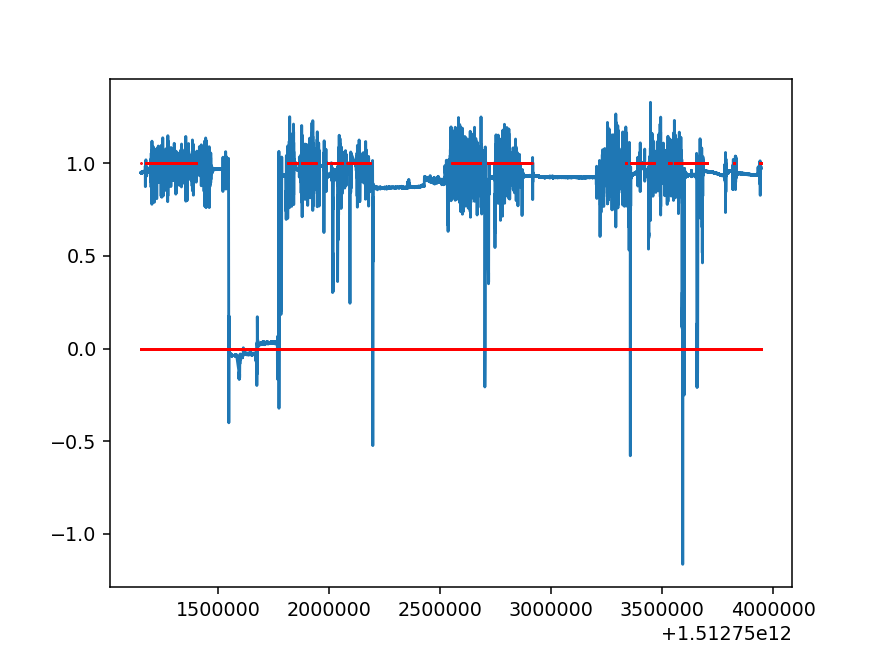

In [2]:
participant_1 = pd.read_pickle('Participant_3.pkl')
#print(participant_1)
labels_1 = np.load('Participant_3_label.npy')
#print(labels_1)

start_time = labels_1[0,0]
end_time = labels_1[-1,0]

dataset = np.copy(participant_1.values)
print(dataset.shape)
print(labels_1.shape)

delta = 40
dataset = dataset[dataset[:,0] >= start_time,:]
dataset = dataset[dataset[:,0] < end_time + delta,:]
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],labels_1[:,2],'r.', ms = 1)
plt.show()

Counter({0.0: 66958, 1.0: 2135, 2.0: 725})
(66958, 1)
(66958, 15)


<IPython.core.display.Javascript object>


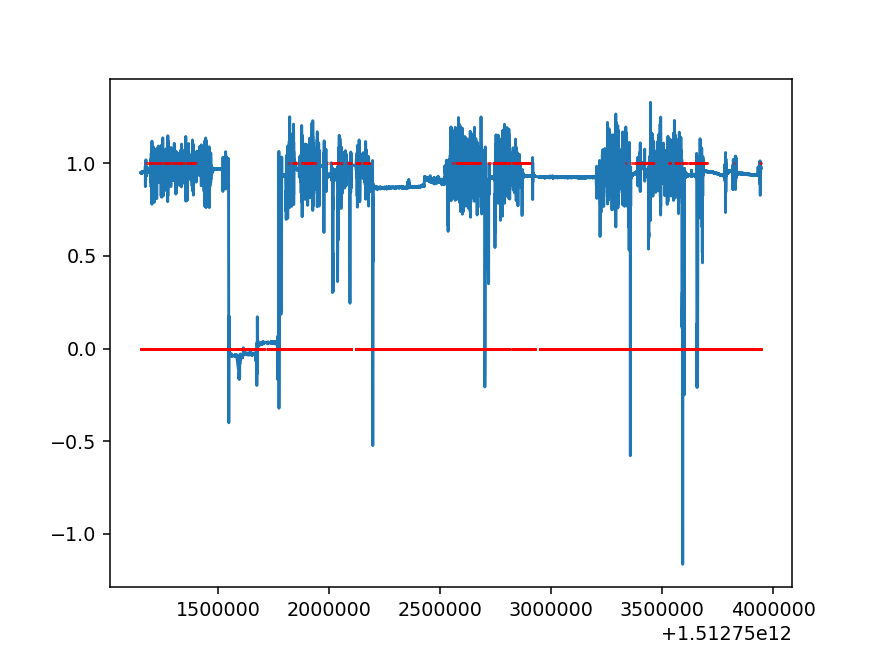

In [3]:
# Remove Missing Data:
missing_1 = dataset[:,13] + dataset[:,14]
print(Counter(missing_1))

dataset = dataset[np.where(missing_1 == 0)]
speed_labels = labels_1[np.where(missing_1 == 0),2].reshape((-1,1))

print(speed_labels.shape)
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],speed_labels,'r.', ms = 0.1)
plt.show()

In [4]:
dataset_cp = np.copy(dataset[:,1:13])

n_samples, d = dataset_cp.shape
window = 10
stride = 10

data_slide = np.zeros((int((n_samples-window)/stride)+1,window,d))
speed_labels_cp = np.zeros((int((n_samples-window)/stride)+1,1))
k=0
for i in range(0,n_samples-window,stride): #400ms
    data_slide[k,:,:] = dataset_cp[i:i+window,:]
    speed_labels_cp[k] = np.sum(speed_labels[i:i+window])
    k=k+1
    
print (data_slide.shape)
print(speed_labels_cp.shape)

(6695, 10, 12)
(6695, 1)


In [5]:
Counter(speed_labels_cp[:,0])

Counter({0.0: 4969,
         1.0: 776,
         2.0: 741,
         3.0: 150,
         4.0: 9,
         5.0: 8,
         6.0: 5,
         7.0: 2,
         8.0: 4,
         9.0: 4,
         10.0: 27})

In [6]:
indices = np.where(np.logical_and(speed_labels_cp > 0, speed_labels_cp < 3 ))[0]
speed_labels_cp[indices,0] = 1
indices = np.where(speed_labels_cp >= 3)[0]
speed_labels_cp[indices,0] = 2

In [7]:
print(Counter(speed_labels_cp[:,0]))
print(np.shape(speed_labels_cp))

Counter({0.0: 4969, 1.0: 1517, 2.0: 209})
(6695, 1)


<IPython.core.display.Javascript object>


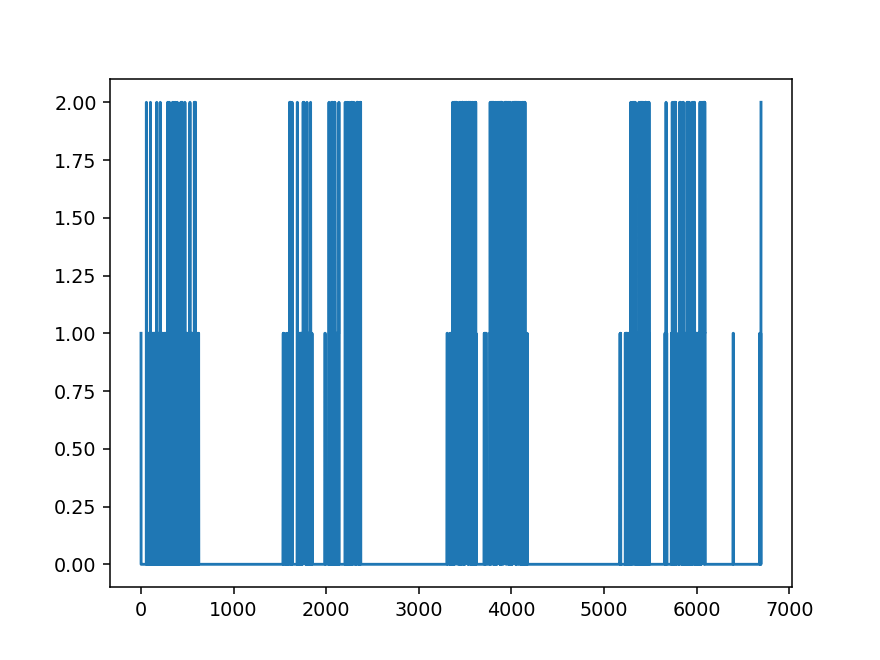

In [8]:
plt.figure()
plt.plot(speed_labels_cp[:,0])
plt.show()

In [9]:
limit = 0
X_train0 = data_slide[0:limit,:]
Y_train = speed_labels_cp[0:limit]
X_valid0 = data_slide[limit:,:]
Y_valid = speed_labels_cp[limit:]
num_classes = 3 #Typing rate
# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_valid = keras.utils.to_categorical(Y_valid, num_classes)

In [10]:
print(np.shape(X_train0))
print(np.shape(Y_train))
print(np.shape(X_valid0))
print(np.shape(Y_valid))

(0, 10, 12)
(0, 3)
(6695, 10, 12)
(6695, 3)


In [37]:
model = load_model('LSTM.h5')
#model = load_model('CNN.h5')
#model = load_model('Conv_LSTM.h5')

In [38]:
#specifying hyper-parameters
batch_size = 128
feat_map_num = 16
num_hidden_lstm = 64
#win_len = 1
_, win_len, dim = X_train0.shape
#_, dim = X_train0.shape
#network_type = 'CNN'
#network_type = 'ConvLSTM'
network_type = 'LSTM'
#network_type = 'MLP'

In [39]:
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    #_, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))
    
    print (np.shape(X_train))
    print (np.shape(X_train))
    return X_train, X_valid

In [40]:
print('reshaping data for different models ...')
X_train, X_valid = _data_reshaping(X_train0, X_valid0, network_type)

reshaping data for different models ...
LSTM
(0, 10, 12)
(0, 10, 12)


In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_pred = np.argmax(model.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid, axis=1)
print('calculating confusion matrix ... ')
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean f1 score:{:.2f}'.format(np.mean(class_wise_f1)))

calculating confusion matrix ... 
[[1694 2941  334]
 [ 650  634  233]
 [  97   82   30]]
the mean f1 score:0.26


<IPython.core.display.Javascript object>


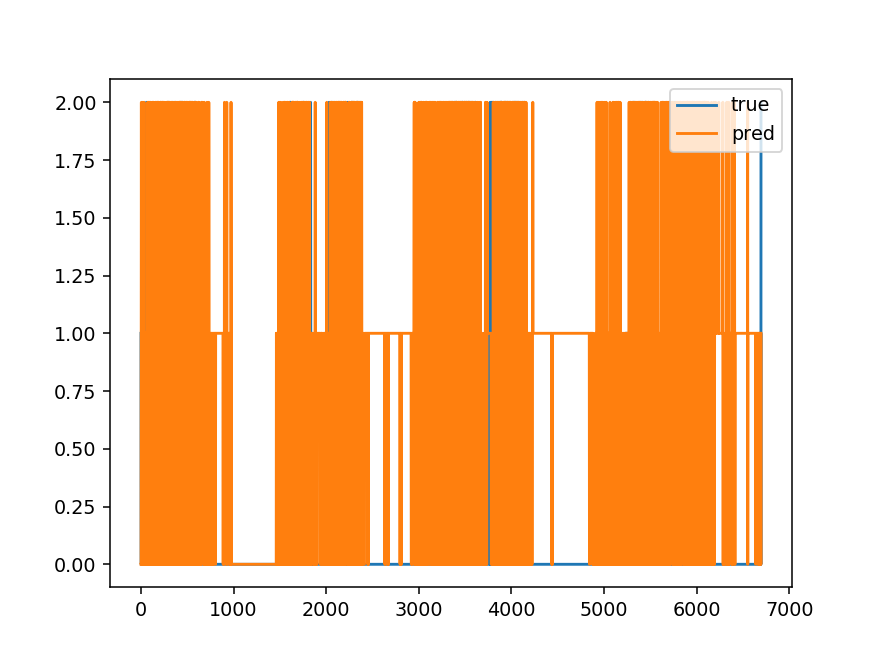

In [43]:
plt.figure()
plt.plot(y_true, label="true")
plt.plot(y_pred, label="pred")

#plt.plot(typing_labels_cp[60000:], label="label")

plt.legend()
plt.show()

In [81]:
model.save('LSTM.h5')

In [ ]:
#Conv_LSTM
calculating confusion matrix ... 
[[4522  445    2]
 [1023  488    6]
 [ 150   58    1]]
the mean f1 score:0.42
    
#CNN
calculating confusion matrix ... 
[[4453  504   12]
 [ 945  566    6]
 [ 138   69    2]]
the mean f1 score:0.43
    
#LSTM
calculating confusion matrix ... 
[[1694 2941  334]
 [ 650  634  233]
 [  97   82   30]]
the mean f1 score:0.26